### Imports

In [10]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO
from neuropy.analyses.decoders import Decode1d

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Useful functions

In [12]:
def plot_decode_with_pos(maze_in: Pf1D, decode_in: Decode1d, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    
    t_decode = maze_in.t_start + np.arange(decode_in.nbins_epochs[0]) * decode_in.bin_size
    ax.pcolormesh(t_decode, decode_in.ratemap.coords.squeeze(), decode_in.posterior[0], cmap="rocket_r")
    ax.plot(maze_in.t, maze_in.x, 'b', linewidth=0.25, label="Actual position")
    ax.legend()

    sns.despine(ax=ax)

In [13]:
from copy import deepcopy
def get_decoder_error(decode_in: Decode1d, maze_in: Pf1D, speed_thresh=10):
    """Get decoding error"""

    # Get actual time and position info
    maze_t = maze_in.t
    maze_x = maze_in.x
    maze_speed = maze_in.speed

    # Get decoder time and interpolate position and speed
    t_decode = maze_t.min() + np.arange(decode_in.nbins_epochs[0]) * decode_maze.bin_size
    pos_interp = np.interp(t_decode, maze_t, maze_x)
    speed_interp = np.interp(t_decode, maze_t, maze_speed)
    speed_thresh_bool = speed_interp > speed_thresh

    # Calculate error for all points and for moving times only
    error = decode_in.decoded_position[0] - pos_interp
    error_moving = deepcopy(error)
    error_moving[~speed_thresh_bool] = np.nan

    return error, error_moving

### Visualize running behavior for all rats and tally lap #s by hand

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
# sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
sessions = subjects.remaze_realign_sess()[1:]  # RatSDay2NSD does not have remaze position info

In [19]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette("muted", as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap_extra = sns.color_palette("dark", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])
cmap3 = cmap3[0:4]
cmap3

cmap4 = []
for c1, c2, ce in zip(cmap1, cmap2, cmap_extra):
    cmap4.extend([c1, c2, ce])
cmap4 = cmap4[0:6]


## Plot decoding example and errors

### Examples first

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/plotting/figure.py:267: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(filename, format=format, dpi=dpi)


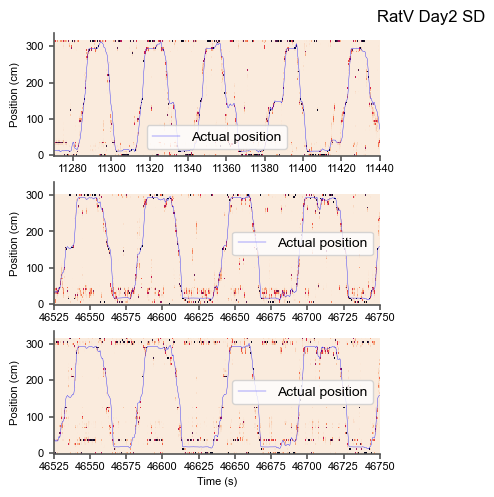

In [17]:
kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10, sigma=0)
sigma2 = 1.5 # additional smoothing for calculating placefield widths, done in bin units, AFTER tuning curve is created
frate_thresh_post_hoc = 3

bin_size = 0.5  # seconds
separate_run_dir = False

sess = sessions[-2]

fig = Fig(16, 12)
fig.fig.suptitle(f"{sess.animal.name} {sess.animal.day} {sess.tag}")
ax1 = fig.subplot(fig.gs[0:2, 0:5])
ax2 = fig.subplot(fig.gs[2:4, 0:5], sharey=ax1)
ax3 = fig.subplot(fig.gs[4:6, 0:5], sharex=ax2, sharey=ax1)
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")

maze_run = sess.maze_run
run_bool = sess.maze.get_smoothed(0.1).speed > kw["speed_thresh"]
run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
neurons_maze = neurons.neuron_slice(neuron_ids=pfmaze.neuron_ids)

remaze_run = sess.remaze_run
rm_run_bool = sess.remaze.get_smoothed(0.1).speed > kw["speed_thresh"]
rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
neurons_remaze = neurons.neuron_slice(neuron_ids=pfremaze.neuron_ids)
#     fr_max = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T

decode_maze = Decode1d(neurons=neurons_maze, ratemap=pfmaze, epochs=sess.paradigm['maze'], bin_size=bin_size)
decode_remaze = Decode1d(neurons=neurons_remaze, ratemap=pfremaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)
decode_maze_remaze = Decode1d(neurons=neurons_maze, ratemap=pfmaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)

for stype, maze_in, decode_in, ax in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [pfmaze, pfremaze, pfremaze],
                                             [decode_maze, decode_remaze, decode_maze_remaze], [ax1, ax2, ax3]):
    err, err_mv = get_decoder_error(decode_in, maze_in, speed_thresh=kw["speed_thresh"])

    plot_decode_with_pos(maze_in, decode_in, ax)
    
ax1.set_xlim((11270, 11440))
ax2.set_xlim((46525, 46750))
[a.set_ylabel("Position (cm)") for a in [ax1, ax2, ax3]]
ax3.set_xlabel("Time (s)")

fig.savefig(plot_dir / "Decoding_examples.pdf")

### Now quantify errors

In [26]:
decode_err_thresh_df.grp == "SD"

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
Name: grp, dtype: bool

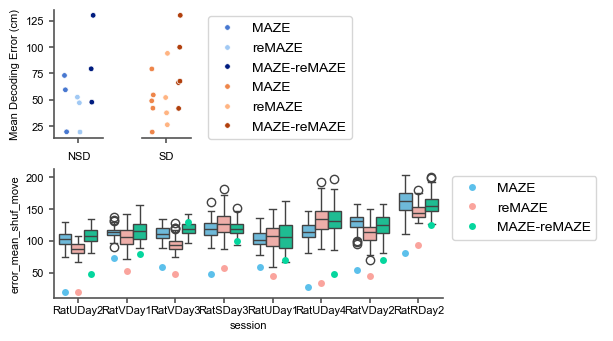

In [67]:
decode_err_shuf_df = pd.read_csv(group_data_dir / "maze_remaze_decode_error_shuffle.csv")
decode_err_thresh_df = pd.read_csv(group_data_dir / "maze_remaze_decode_error_speed_thresh.csv")

fig = Fig(16, 12)

handles, labels = [], []
for idg, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[0:2, idg])
    df_grp = decode_err_thresh_df[decode_err_thresh_df.grp == grp]
    cmap_use = cmap4[(idg*3):(idg + 1)*3]
    sns.stripplot(data=df_grp, y="error_mean_move", hue="decode_type", dodge=True, palette=cmap_use, 
                  size=4, edgecolor="w", linewidth=0.5, legend=True, 
                  ax=ax)
    handles1, labels1 = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    handles = handles + handles1
    labels = labels + labels1
    
    if idg == 0:
        ax.set_ylabel('Mean Decoding Error (cm)')
    else:
        sns.despine(ax=ax, left=True)
        ax.set_ylabel("")
        ax.set_yticks([])
    
    ax.set_xlabel(grp)

axl = fig.subplot(fig.gs[0:2, 2:4])
axl.legend(handles, labels, loc='best')
sns.despine(ax=axl, bottom=True, left=True)
axl.set_yticks([])
axl.set_xticks([])

# Plot shuffled distributions
ax = fig.subplot(fig.gs[2:4, 0:5])
sns.boxplot(data=decode_err_shuf_df, x="session", y="error_mean_shuf_move", hue="decode_type", dodge=True, 
            legend=False, ax=ax)
sns.stripplot(data=decode_err_thresh_df, x="session", y="error_mean_move", hue="decode_type", dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

axl = fig.subplot(fig.gs[2:4, 5:7])
axl.legend(handles, labels)
sns.despine(ax=axl, bottom=True, left=True)
axl.set_yticks([])
axl.set_xticks([])

fig.savefig(plot_dir / "decoding_errors.pdf")

## Plot PV correlations

In [77]:
def mean_of_rotated_array(rot_array, nan_ctr=True):
    sums = rot_array.sum(axis=0)
    denom = (rot_array != 0).sum(axis=0)

    if nan_ctr:
        sums[np.floor(sums.shape[0]/2 - 0.5).astype(int):np.ceil(sums.shape[0]/2 + 0.5).astype(int)] = np.nan

    return sums / denom

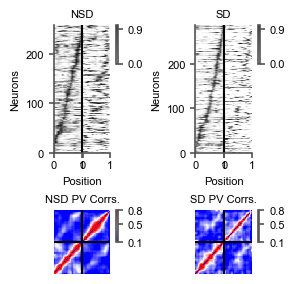

In [82]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

tc_all = pd.read_csv(group_data_dir / "tc_all.csv", index_col=0)
df_comb = pd.read_csv(group_data_dir / "pf_comb.csv", index_col=0)

fig = Fig(16, 12)

exclude_nan = False
frate_thresh = 3 # TODO
thresh_method = "maze"  #  "maze" makes sense (only look at legit place cells from first session), "remaze" and "both" could be implemented in the future to assess future field formation...  
sort_by = "MAZE"  # How sort placefields
# Scale activity to overall max across MAZE and reMAZE ("all"), by each maze individually ("by_maze"), or scale to MAZE max ("maze")
scale_row_method = "by_maze" 
assert scale_row_method in ["by_maze", "maze", "all"]
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array

    # Old method
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    # tc_grp = gaussian_filter1d(tc_grp, sigma=sigma2, axis=1)
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # New method - matches old
    tc_maze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    maze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")]["FRmax"]
    tc_remaze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    remaze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")]["FRmax"]
    nbins_per_sesh = np.shape(tc_maze_temp)[1]
    tc_grp2 = np.hstack((tc_maze_temp.to_numpy(), tc_remaze_temp.to_numpy()))
    tc_grp = tc_grp2
    fr_bool = (maze_max_fr > frate_thresh).values if thresh_method == "maze" else False
    assert isinstance(fr_bool, np.ndarray), "thresh_method other than 'maze' not implemented yet"
    tc_grp = tc_grp[fr_bool]
    tc_grp = tc_grp + np.random.randn(tc_grp.shape[0], tc_grp.shape[1])*1e-10  # Add in random noise to prevent generating nans in PV mat
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    if scale_row_method == "by_maze":
        tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
        tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    elif scale_row_method == "all":
        tc_new = min_max_scaler(tc_grp, axis=1)
        print('test')
        # tc_new =  min_max_scaler(tc_grp,axis=-1)
    elif scale_row_method == "maze":
        maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        tc_new[:, :nbins_per_sesh] = min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)
        tc_new[:, nbins_per_sesh:] = min_max_external_scaler(tc_grp[:, nbins_per_sesh:], maze_min, maze_ptp)
        

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True, vmin=0, vmax=1)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/83204716.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/Users/nkinsky/mambaforge/envs/NeuroPy3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/1564255726.py:64: RuntimeWarning: Mean of empty slice
  rot_mean = np.nanmean(rotate_diff, axis=0)
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/83204716.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/Users/nkinsky/mambaforge/envs/NeuroPy3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/1564255726.py:64: RuntimeWarning: M

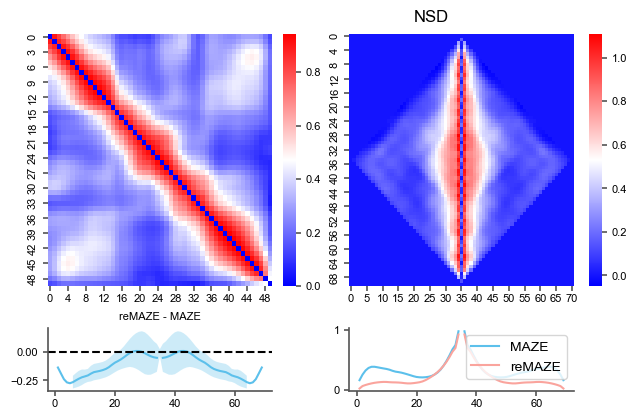

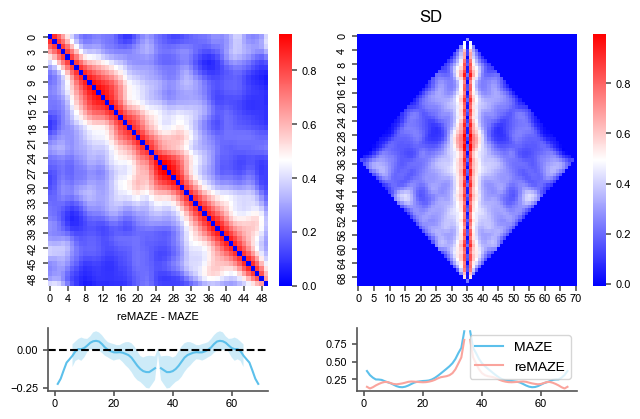

In [93]:
from scipy.ndimage import rotate

# Specify if you want to downsample maze for each session to match remaze
ds_by = "remaze"
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)

# Ditto for remaze
ds_remaze_by = None
assert (ds_remaze_by is None) or isinstance(ds_remaze_by, int)

maze_rotate_all, remaze_rotate_all = [], []
for idg, group in enumerate(["NSD", "SD"]):
#     fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    fig = Fig(16, 12)
    # fig = plotting.Fig(11, 8)
    
    fig.fig.suptitle(group)
    ax00 = fig.subplot(fig.gs[0:4, 0:4])
    ax01 = fig.subplot(fig.gs[0:4, 4:8])
    ax10 = fig.subplot(fig.gs[4, 0:4])
    ax11 = fig.subplot(fig.gs[4, 4:8])
    
    ax = np.array([[ax00, ax01], [ax10, ax11]])
    
    maze_test = corr_all[idg][0:50, 0:50]
    remaze_test = corr_all[idg][50:100, 50:100]
    sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")

    maze_test_rotate = rotate(maze_test, 135, reshape=True)
    remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")

    maze_rotate_all.append(maze_test_rotate)
    remaze_rotate_all.append(remaze_test_rotate)
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True) - mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = remaze_test_rotate - maze_test_rotate
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)

    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    ax[1, 0].set_title("reMAZE - MAZE")
    fig.savefig(plot_dir / f"{group}_PVcorr_sharpening_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/83204716.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_59682/1822841336.py:48: RuntimeWarning: Mean of empty slice
  rot_mean = np.nanmean(rotate_diff, axis=0)


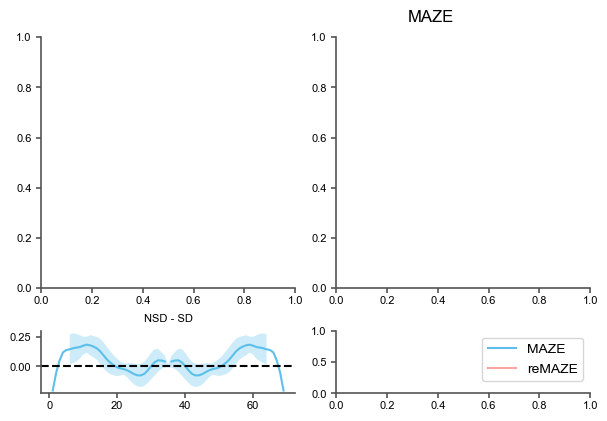

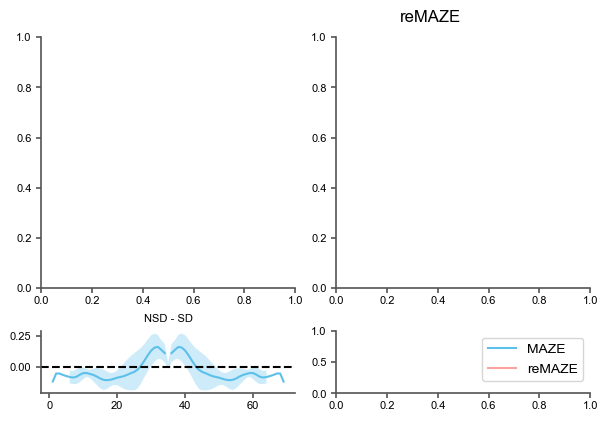

In [91]:
for idg, (mname, rot_arrays) in enumerate(zip(["MAZE", "reMAZE"], [maze_rotate_all, remaze_rotate_all])):
#     fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    fig = Fig(16, 12)
    
    fig.fig.suptitle(mname)
    ax00 = fig.subplot(fig.gs[0:4, 0:4])
    ax01 = fig.subplot(fig.gs[0:4, 4:8])
    ax10 = fig.subplot(fig.gs[4, 0:4])
    ax11 = fig.subplot(fig.gs[4, 4:8])
    
    ax = np.array([[ax00, ax01], [ax10, ax11]])
    
    # maze_test = corr_all[idg][0:50, 0:50]
    # remaze_test = corr_all[idg][50:100, 50:100]
    # sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")
    
    # maze_test_rotate = rotate(maze_test, 135, reshape=True)
    # remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    # sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    # hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    # hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(rot_arrays[0], nan_ctr=True) - mean_of_rotated_array(rot_arrays[1], nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = rot_arrays[0] - rot_arrays[1]
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)
    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    ax[1, 0].set_title("NSD - SD")
#     fig.savefig(plot_dir / f"{mname}_PVcorr_sharpening_by_maze_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")